In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from dataset_functions import *
seed = 10  
np.random.seed(seed=seed)

# Preprocessing 
Feature *chat_len*  dropped (not useful).

Feature *match_id_hash* dropped (not useful).

Feature *lobby_type* dropped (only 0 or 7 appears which means public and ranked matchmaking, we consider both but the feature does not give us important meaning so we drop it)

Feature *game_mode* contains different values, however we are only interested in values 2 and 22, which represents the standard gamemodes for dota2 (Captain’s Mode and Ranked All Pick), so we filter the row with those value and then drop the label.

Feature *game_time* represents the time of the game at which we have the information needed to make the prediction. By checking the data we found a lot of *game_time=0* but with some objectives already destroyed, we decided to drop all *game_time=0* rows since it probably is an error from the APIs (Nan/not avaiable replaced with 0 maybe).

Every player has *rx_teamfight_participation*(or dx_) as a percentage of tf each player has partecipated, some where >1 and we decided to replace them with 1.

In [4]:
featureset_path = "../dataset/mlcourse-dota2-win-prediction/train_features.csv"
feature = pd.read_csv(featureset_path)
lobby_type_counts = feature['lobby_type'].value_counts()
game_mode_counts = feature['game_mode'].value_counts()
game_time_counts = feature[feature['game_time']==0]["game_time"].value_counts()
print(lobby_type_counts)
print(game_mode_counts)
print(game_time_counts)

lobby_type
7    27049
0    12626
Name: count, dtype: int64
game_mode
22    31762
4      3564
23     2546
3      1200
2       408
5       188
12        5
16        2
Name: count, dtype: int64
game_time
0    20
Name: count, dtype: int64


In [ ]:
print(f"Data shape before preprocessing: {feature.shape}")
df, target = get_dataset()
print(f"Data shape after preprocessing: {df.shape}")

Data shape before preprocessing: (39675, 246)
Filtering Df:  (game_mode == 2 or game_mode == 22) and game_time > 0 

Dropped:  ['lobby_type', 'chat_len', 'game_mode', 'match_id_hash'] 

Dataframe Shape:  (32153, 242) 

Target shape: (32153, 6)


# Deciding dataset
We need to handle categorical variables, the only present are the id of the hero that each player is currently playing: *r1_hero_id*.

One hot encoding is implemented to handle them but in different ways, since our initial plan was to try 3 different version of the data: 
 - *playerstats_playerheros*, considering statistic for each player (already in the dataset) and the hero he uses, this leads to the addition of 1.140 columns via one hot encoding for each hero for each player 

 - *playerstats_teamheros*, considering statistic for each player (already in the dataset) but not considering each players herom, we only consider if a hero is present in team_radiandt or in team_dire, this way one hot encoding only adds 220 columns (as final result, all the single players hero *r2_hero_id* gets dropped)

 - *teamstats_teamheros*, now we consider heros in overall team and not for each player + we sum all the statistic of the individual player into team statistics, only adding 52 features (as final result, because almost every indiviual stat gets dropped after the creation of the team statistic)

In [36]:
df_playerstats_playerheros = df.copy()
df_playerstats_teamheros = df.copy()
df_teamstats_teamheros = df.copy()

df_playerstats_playerheros = playerstats_playerheros_transform(df_playerstats_playerheros)
print(f"original data shape after pre processing{df.shape}" )
print(f"data shape playerstats_playerheros {df_playerstats_playerheros.shape}" )

original data shape after pre processing(32153, 242)
data shape playerstats_playerheros (32153, 1382)


In [37]:
df_playerstats_teamheros = playerstats_teamheros_transform(df_playerstats_teamheros)
print(f"original data shape after pre processing{df.shape}" )
print(f"data shape playerstats_teamheros {df_playerstats_teamheros.shape}" )

Hero Id Labels: ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'] 

Numbers of Heros:  115 

Dataframe Shape: (32153, 462) 

NaN Count:  0 

original data shape after pre processing(32153, 242)
data shape playerstats_teamheros (32153, 462)


In [38]:
df_teamstats_teamheros = teamstats_teamheros_transform(df_teamstats_teamheros)
print(f"original data shape after pre processing{df.shape}")
print(f"data shape teamstats_teamheros {df_teamstats_teamheros.shape}" )

Hero Id Labels: ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'] 

Numbers of Heros:  115 

NaN Count:  0 

Single Player Labels: ['r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed', 'r2_kills', 'r2_deaths', 'r2_assists', 'r2_denies', 'r2_gold', 'r2_lh', 'r2_xp', 'r2_health', 'r2_max_health', 'r2_max_mana', 'r2_level', 'r2_x', 'r2_y', 'r2_stuns', 'r2_creeps_stacked', 'r2_camps_stacked', 'r2_rune_pickups', 'r2_firstblood_claimed', 'r2_teamfight_participation', 'r2_towers_killed', 'r2_roshans_killed', 'r2_obs_placed', 'r2_sen_placed', 'r3_kills', 'r3_deaths', 'r3_assists', 'r3_denies', 'r3_gold', 'r

In [39]:
win = target["radiant_win"].astype(int)

## functions to determine feature importance

In [40]:
def fit_feature_selector(X_train:pd.DataFrame,Y_train:pd.DataFrame) -> RandomForestClassifier:
    feature_selector = RandomForestClassifier(max_depth=10,random_state=seed)

    feature_selector.fit(X_train,Y_train)

    return feature_selector

def feature_importance(
        feature_selector:RandomForestClassifier,
        X_test:pd.DataFrame,
        Y_test:pd.DataFrame
    ):
    
    Y_pred = feature_selector.predict(X_test)

    acc = accuracy_score(Y_test,Y_pred)
    auc = roc_auc_score(Y_test,Y_pred)

    print("Accouracy:\t",acc)
    print("Roc Auc:\t",auc)

    feature_importance = {
        name: value 
        for name,value in zip(feature_selector.feature_names_in_,feature_selector.feature_importances_)
    }

    feature_importance = dict(reversed(sorted(feature_importance.items(), key=lambda item: item[1])))
    feature_names = list(feature_importance.keys())
    print("Most Important:\n", feature_names[:10])
    print("Least Important:\n", feature_names[-10:])

    

## playerstats_playerheros

In [41]:
X_train,X_test,Y_train,Y_test = train_test_split(df_playerstats_playerheros,win,test_size=0.2)

feature_selector = fit_feature_selector(X_train,Y_train)
feature_importance(feature_selector,X_test,Y_test)

Accouracy:	 0.6967812159850723
Roc Auc:	 0.6889758436009565
Most Important:
 ['r2_y', 'r4_y', 'r5_x', 'd3_x', 'd1_x', 'r5_y', 'r1_y', 'r1_x', 'd2_x', 'd3_y']
Least Important:
 ['r3_hero_id_15', 'r2_hero_id_89', 'r2_hero_id_51', 'r2_hero_id_38', 'r1_hero_id_80', 'r1_hero_id_66', 'r1_hero_id_65', 'r1_hero_id_55', 'r1_hero_id_43', 'r1_hero_id_20']


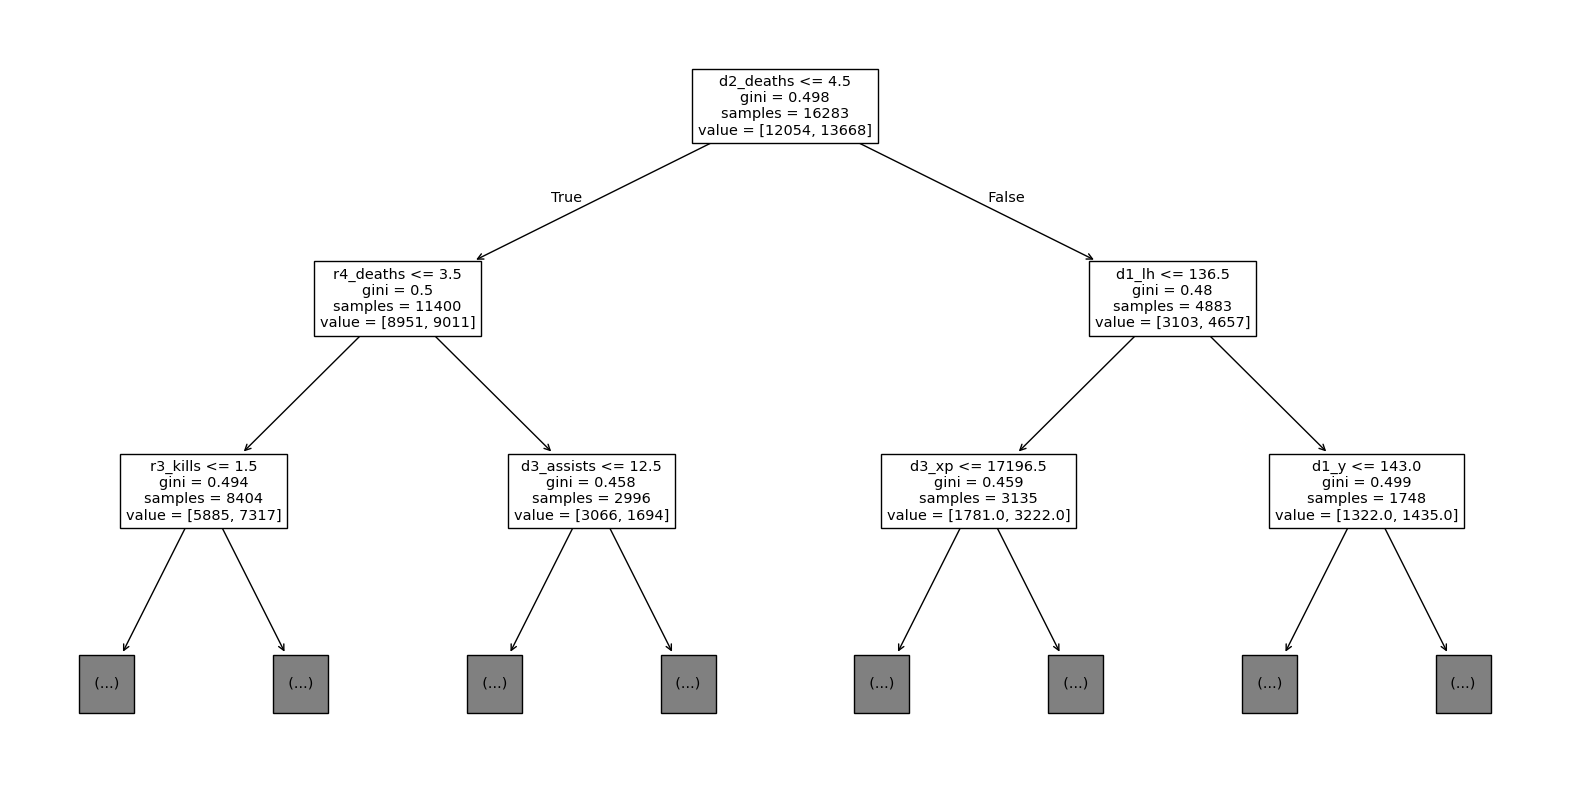

In [42]:
tree = feature_selector.estimators_[1]

plt.figure(figsize=(20,10))
plot_tree(tree,max_depth=2,feature_names=df_playerstats_playerheros.columns)
plt.show()

## playerstats_teamheros

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(df_playerstats_teamheros, win, test_size=0.2)

# Train the RandomForestClassifier
feature_selector = fit_feature_selector(X_train,Y_train)
feature_importance(feature_selector, X_test, Y_test)

Accouracy:	 0.6967812159850723
Roc Auc:	 0.6873442872073152
Most Important:
 ['r3_x', 'r1_y', 'd3_y', 'r3_y', 'r2_x', 'r4_y', 'd5_x', 'd3_x', 'r5_y', 'r1_x']
Least Important:
 ['r_66', 'r_78', 'd_66', 'd_45', 'd_90', 'r_80', 'd_82', 'r_55', 'r_38', 'r_89']


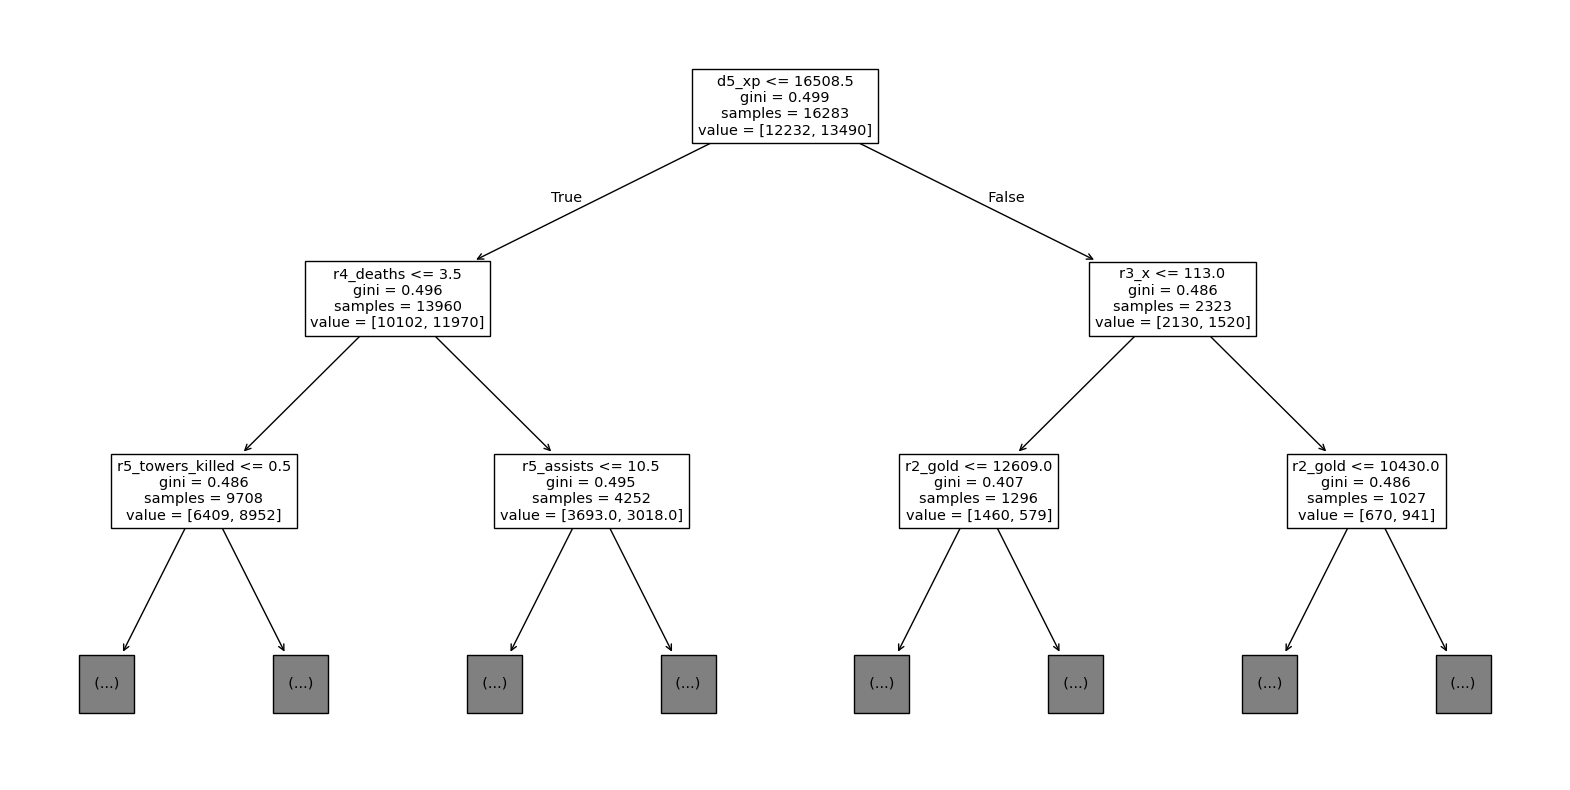

In [44]:
# Plot one of the trees in the forest
tree = feature_selector.estimators_[1]
plt.figure(figsize=(20, 10))
plot_tree(tree, max_depth=2, feature_names=df_playerstats_teamheros.columns)
plt.show()

## teamstats_teamheros

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(df_teamstats_teamheros, win, test_size=0.2)

# train the RandomForestClassifier
feature_selector = fit_feature_selector(X_train,Y_train)

feature_importance(feature_selector, X_test, Y_test)

Accouracy:	 0.7047115534131551
Roc Auc:	 0.6964905783980118
Most Important:
 ['r_deaths', 'r_towers_killed', 'd_towers_killed', 'd_kills', 'd_deaths', 'r_kills', 'r1_y', 'd_gold', 'd2_y', 'r_gold']
Least Important:
 ['r_103', 'r_38', 'r_73', 'r_33', 'd_66', 'r_66', 'r_37', 'r_61', 'r_55', 'r_82']


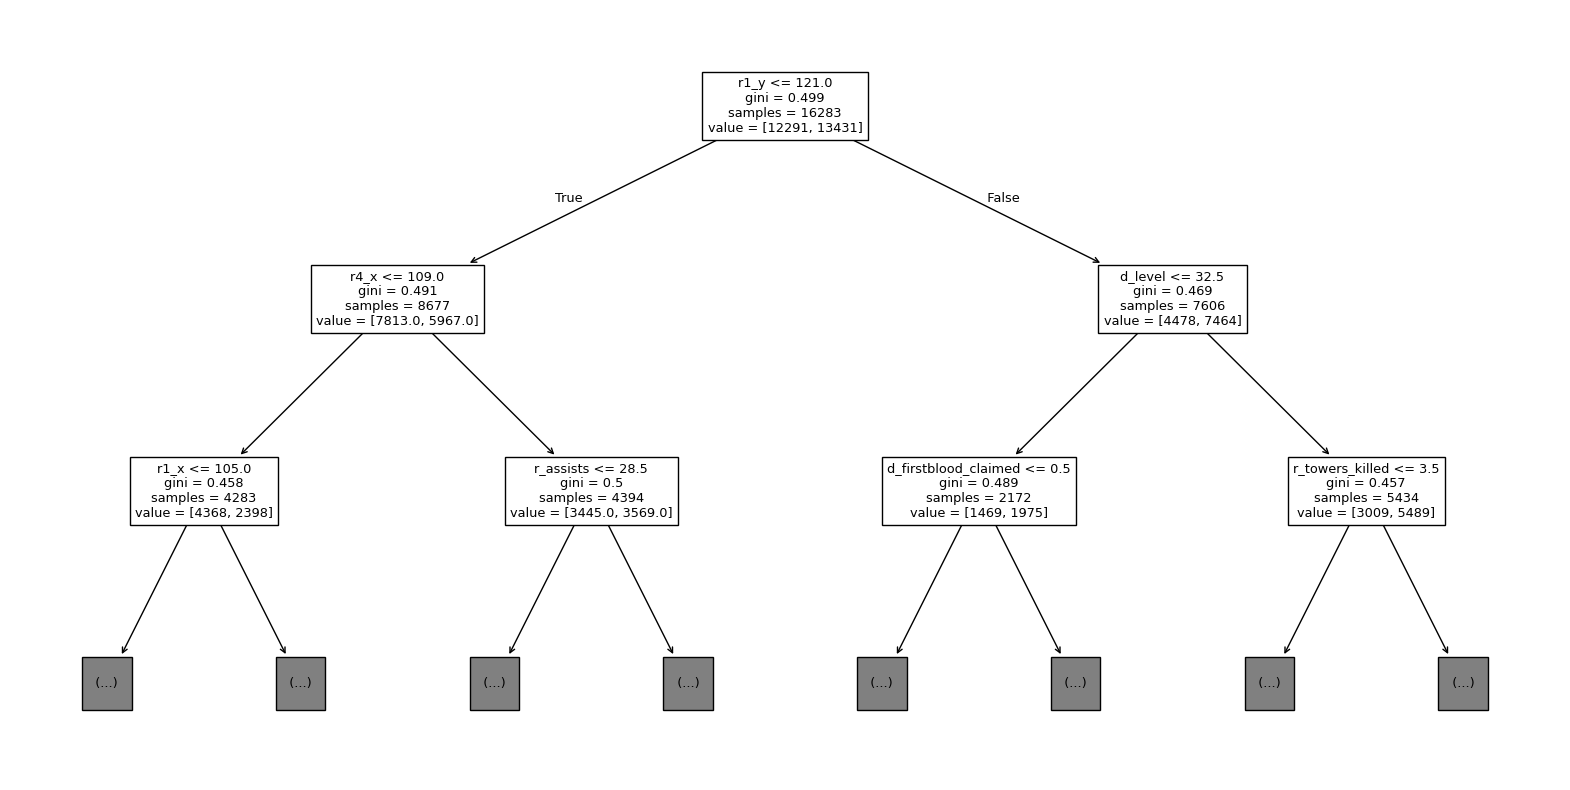

In [46]:
tree = feature_selector.estimators_[1]
plt.figure(figsize=(20, 10))
plot_tree(tree, max_depth=2, feature_names=df_teamstats_teamheros.columns)
plt.show()

# Chosen dataset
The approach that consider overall team statistics and team usage of heroes (teamstats_teamheros) seems the most promising, the model even considers some team statistic to be the most important features (*towers_killed, deaths, kills and gold*). 

Other than some team statistics, all the forest agree that the position of the players are really important, in order to improve on this side we will add features to give an overall position of the team and not of individual players, to do this we tried 2 similar approaches: 
- adding features considering the arithmetic mean of the position of all players in the same team (*radiant_avg_x, radiant_avg_y, dire_avg_x, dire_avg_y*) and dropping all individual player position, this way we reduce the number of feature by 16

- adding features considering a Weighted arithmetic mean of the position of all players in the same team, each position has weight equal to $\frac{1}{mean \  distance\ between\ all\ other\ teammates}$, this way the position of the team will be more centered around the area with more people (*radiant_Weighted_avg_x, radiant_Weighted_avg_y, dire_Weighted_avg_x, dire_Weighted_avg_y*) and dropping all individual player position, this way we reduce the number of feature by 16.

## team_mean_position

In [47]:
df_teamstats_teamheros_mean_position = df_teamstats_teamheros.copy()
df_teamstats_teamheros_mean_position = team_mean_position_transform(df_teamstats_teamheros_mean_position)

X_train, X_test, Y_train, Y_test = train_test_split(df_teamstats_teamheros_mean_position, win, test_size=0.2)
feature_selector = fit_feature_selector(X_train,Y_train)

feature_importance(feature_selector, X_test, Y_test)

Accouracy:	 0.7141968589643912
Roc Auc:	 0.7097074849857441
Most Important:
 ['radiant_avg_y', 'dire_avg_x', 'dire_avg_y', 'radiant_avg_x', 'd_towers_killed', 'r_kills', 'r_deaths', 'd_kills', 'd_deaths', 'r_towers_killed']
Least Important:
 ['d_58', 'r_113', 'd_60', 'r_90', 'r_80', 'd_112', 'd_65', 'd_55', 'r_55', 'd_66']


## team_weighted_mean_position

In [48]:
df_teamstats_teamheros_weighted_mean_position = df_teamstats_teamheros.copy()
df_teamstats_teamheros_weighted_mean_position = team_weighted_mean_position_transform(df_teamstats_teamheros_weighted_mean_position)

X_train, X_test, Y_train, Y_test = train_test_split(df_teamstats_teamheros_weighted_mean_position, win, test_size=0.2)
feature_selector = fit_feature_selector(X_train,Y_train)

feature_importance(feature_selector, X_test, Y_test)

Accouracy:	 0.7194837505831131
Roc Auc:	 0.7136757683428702
Most Important:
 ['dire_Weighted_avg_y', 'radiant_Weighted_avg_y', 'radiant_Weighted_avg_x', 'dire_Weighted_avg_x', 'd_towers_killed', 'd_kills', 'r_towers_killed', 'd_deaths', 'r_deaths', 'r_kills']
Least Important:
 ['r_103', 'd_80', 'd_112', 'd_52', 'r_60', 'd_66', 'd_113', 'd_82', 'r_66', 'r_55']


Accuracy and Roc Auc both improve and the added feature are considered as most important, we will proceede with our project with teamstats_teamheros dataframe and its two variants with mean_position and weighted_mean_position

Now we proceed with some feature selection to reduce the number of feature in our dataset, probably it will remove all information about heroes since they are consistently the least important across all dataset.